In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from   sklearn.neighbors import KernelDensity
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMZN', 'ANET', 'APPH', 'AXON', 'BROS', 
    'BYND', 'COUR','CPNG', 'DDOG', 'DOCU', 'DUOL', 'EDIT', 'ETSY',
    'FUV', 'GH', 'GMED', 'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 
    'LULU', 'LUV', 'MDB', 'MELI', 'MNST', 'MSFT', 'MTCH', 'NVCR', 
    'NVDA', 'OKTA', 'PANW', 'PINS', 'PTON', 'PUBM', 'QDEL', 
    'RDFN', 'RGEN', 'ROKU', 'SE', 'SHOP', 'SPLK', 'TDOC', 'TEAM', 
    'TREX', 'TSLA', 'TTD', 'TTWO', 'TWLO', 'TWTR', 'UPST', 'VEEV', 
    'ZEN', 'ZG', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

58

In [3]:
TODAY = (datetime.now() + timedelta(1)).date()
START = TODAY - timedelta(5*365)
START, TODAY

(datetime.date(2016, 10, 23), datetime.date(2021, 10, 22))

In [4]:
batch = SYMBOLS + INDICES

In [5]:
data = yf.download(batch, start=START, end=TODAY).rename(columns={'Adj Close': 'AdjClose'})

[*********************100%***********************]  61 of 61 completed


In [6]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [7]:
test = get_stock_data('DUOL', data)
test.head()

,AdjClose,Close,High,Low,Open,Volume
Date,,,,,,
2021-07-28,134.255005,134.255005,145.000000,130.000000,141.399994,2887900.0
2021-07-29,134.440002,134.440002,139.000000,132.000000,137.000000,693900.0
2021-07-30,140.250000,140.250000,141.399994,128.500000,135.179993,617700.0
2021-08-02,143.800003,143.800003,147.250000,134.720001,140.000000,586600.0
2021-08-03,139.860001,139.860001,146.990005,138.009995,143.160004,740100.0


In [8]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [9]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [10]:
get_sharpe(get_daily_returns(test.AdjClose))

1.8587241059558295

In [11]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [12]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [13]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [14]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    sharpe = get_sharpe(get_daily_returns(stock_data.AdjClose))
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    n = stock_data.shape[0]
    WINDOW = min(n, 125)
    stock_data['ann_high'] = (stock_data.Close
                              .rolling(window=WINDOW)
                              .max())
    stock_data['ann_low'] = (stock_data.Close
                             .rolling(window=WINDOW)
                             .min())
    stock_data['drawdown'] = stock_data.Close / stock_data.ann_high
    stock_data['pullup'] = stock_data.Close / stock_data.ann_low
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = ((stock_data.Close 
                            + stock_data.High 
                            + stock_data.Low 
                            + stock_data.Open) 
                           / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.Close / stock_data.est
    stock_data.sort_values('resid', inplace=True)
    stock_data['dev'] = np.array(range(n)) / n
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.Close, label='Close')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(np.sqrt(stock_data.drawdown * stock_data.pullup),
                 color='grey',
                 label='geomean')
        plt.yscale('log')
        plt.legend()
    return (stock_data.direction.tolist()[-1],
            stock_data.rsi.tolist()[-1],
            stock_data.resid.tolist()[-1], 
            stock_data.dev.tolist()[-1],
            stock_data.drawdown.tolist()[-1],
            stock_data.pullup.tolist()[-1],
            sharpe)

(1,
 58.07548971911684,
 1.0376100992203183,
 0.8330683624801272,
 0.927360301600688,
 1.4431785088525002,
 0.5444090140459902)

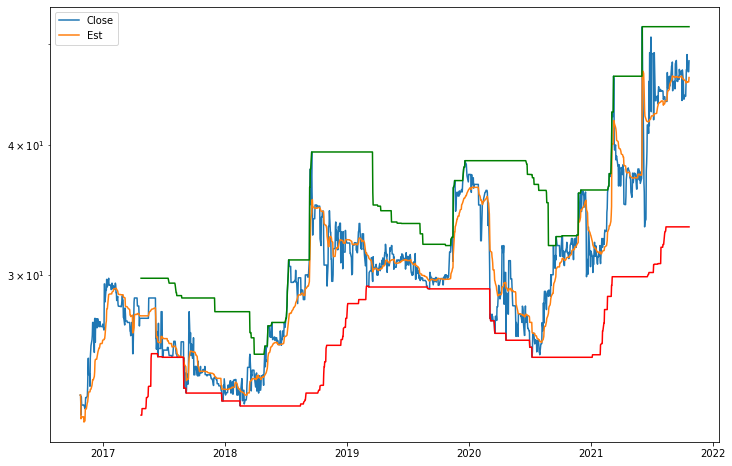

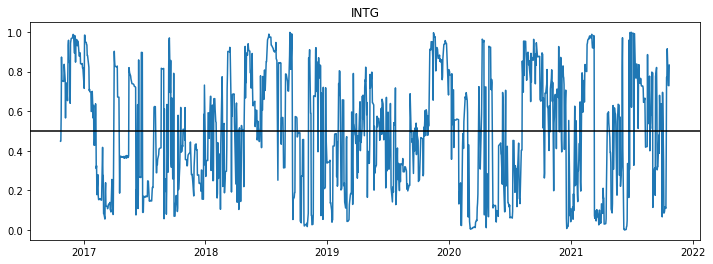

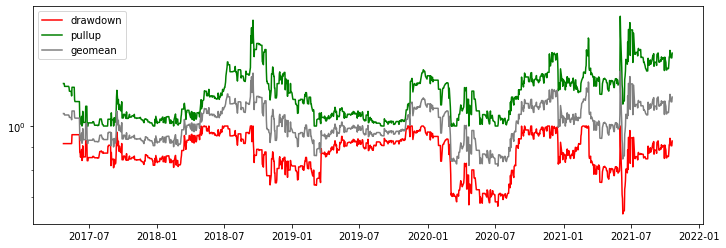

In [15]:
process_stock('INTG', data.copy(), plot=True)

In [16]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    direction, rsi, mult, dev, drop, climb, sharpe = process_stock(
        stock, data)
    out.append([stock, direction, rsi, mult, dev, drop, climb, sharpe])

AAPL... ABMD... ABNB... AMZN... ANET... APPH... AXON... BROS... BYND... COUR... CPNG... DDOG... DOCU... DUOL... EDIT... ETSY... FUV... GH... GMED... GOOG... INTG... ISRG... JD... LSPD... LULU... LUV... MDB... MELI... MNST... MSFT... MTCH... NVCR... NVDA... OKTA... PANW... PINS... PTON... PUBM... QDEL... RDFN... RGEN... ROKU... SE... SHOP... SPLK... TDOC... TEAM... TREX... TSLA... TTD... TTWO... TWLO... TWTR... UPST... VEEV... ZEN... ZG... ZNGA... ^GSPC... ^IXIC... ^NYA... 

In [17]:
out = pd.DataFrame(
    data=out, 
    columns=['stock', 'direction', 'RSI', 'fair_value_mult', 
             'dev_quantile', 'drop','climb', 'sharpe'])
out['geomean'] = np.sqrt(out['drop'] * out.climb)
out.loc
out['score'] = (out.fair_value_mult
                * out.dev_quantile
                * out['drop']
                * out.climb) ** (1/4) 
out.RSI *= 100
out['RSIRev'] = 10000 - out.RSI
out = out[['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
           'dev_quantile', 'drop', 'climb','geomean', 'score', 
           'sharpe']]
out.RSI.fillna(out.RSI.median())
out.RSIRev.fillna(out.RSIRev.median())

out.sort_values('score')

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe
14,EDIT,0,3525.465672,6474.534328,0.900678,0.099364,0.527420,1.229466,0.805261,0.490815,0.628301
5,APPH,1,3343.419980,6656.580020,0.903305,0.250000,0.277030,1.027726,0.533584,0.503553,-0.039811
25,LUV,0,3676.523542,6323.476458,0.950606,0.090620,0.775088,1.027449,0.892392,0.511781,0.286295
28,MNST,0,2769.452033,7230.547967,0.978363,0.169316,0.862942,1.003768,0.930695,0.615465,0.524802
47,TREX,0,3808.199477,6191.800523,0.973719,0.175676,0.838221,1.048855,0.937642,0.622737,1.101138
...,...,...,...,...,...,...,...,...,...,...,...
42,SE,1,6480.352309,3519.647691,1.069679,0.765873,0.989945,1.795493,1.333206,1.098503,1.641258
48,TSLA,1,8215.637817,1784.362183,1.091687,0.871224,1.000000,1.586625,1.259613,1.108347,1.344740
44,SPLK,1,7117.759503,2882.240497,1.077295,0.929253,1.000000,1.507680,1.227876,1.108395,0.701126
53,UPST,0,6162.351410,3837.648590,1.042301,0.415888,0.908564,4.215824,1.957127,1.135146,2.457902


In [18]:
out = out.sort_values('stock')
out.to_csv('../data/scoring.csv', index=False)
!open ../data/scoring.csv

In [19]:
try:
    historic = pd.read_csv('../data/historic.csv')
    historic = pd.concat([historic, out])
except FileNotFoundError:
    historic = out
    
print(historic.shape)

(2274, 11)


In [20]:
historic = historic[historic.score > 0]
#historic[historic.RSI < 1000] = np.nan
historic.to_csv('../data/historic.csv', index=False)

In [21]:
historic.drop('stock', axis=1).quantile([0.004, 0.01, 0.05, 0.95, 0.99, 0.996])

,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe,direction,RSI,RSIRev
0.004,0.809191,0.008136,0.289487,1.000000,0.547807,0.286958,-1.559610,0.0,2609.667801,2106.334440
0.010,0.861455,0.021302,0.324853,1.000000,0.589522,0.341776,-1.496082,0.0,2672.214792,2205.908233
0.050,0.910630,0.060060,0.556857,1.004486,0.771658,0.454897,0.272653,0.0,3372.342508,2990.851138
0.950,1.076918,0.850487,1.000000,1.940549,1.371548,1.093836,1.629590,1.0,7009.148862,6627.657492
0.990,1.185111,0.935484,1.000000,3.709886,1.871735,1.219263,2.494534,1.0,7794.091767,7327.785208
0.996,1.199142,0.961647,1.000000,4.491354,2.048758,1.363366,2.560092,1.0,7893.665560,7390.332199
